In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import time
from IPython import display
%matplotlib inline


## See https://github.com/matthias-research/pages/blob/master/tenMinutePhysics/17-fluidSim.html


/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
@nb.njit
def nb_integrate( f_dt, v, s ):
    Nx,Ny = s.shape
    for i in range(1,Nx):
        for j in range(1,Ny-1):
            if ( s[i,j] != 0 and s[i,j-1] != 0 ):
                v[i,j] += f_dt

@nb.njit
def nb_solveInc( maxNiter, cp,m1_soRel, u,v,s,p ):
    Nx,Ny = s.shape
    for itr in range(maxNiter):
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):

                if s[i,j] == 0:
                    continue

                sx0 = s[i-1,j]
                sx1 = s[i+1,j]
                sy0 = s[i,j-1]
                sy1 = s[i,j+1]

                div = u[i+1,j] - u[i,j] + v[i,j+1] - v[i,j]
                # minus one over sf times the overRelaxation factor
                pp = div * m1_soRel[i,j]
                p[i,j] += cp * pp

                u[i,j]   -= pp * sx0
                u[i+1,j] += pp * sx1
                v[i,j]   -= pp * sy0
                v[i,j+1] += pp * sy1

@nb.njit
def nb_sampleField( x,y,f,h,dx,dy):

    h1 = 1.0 / h
    h2 = h/2
    
    Nx,Ny = f.shape
    Lx = Nx*h
    Ly = Ny*h

    x = max( min( x, Lx), h)
    y = max( min( y, Ly), h)

    x0 = int(min(np.floor((x-dx)*h1), Nx-1))
    tx = ((x-dx)-x0*h) * h1
    x1 = min(x0+1,Nx-1)

    y0 = int(min(np.floor((y-dy)*h1), Ny-1))
    ty = ((y-dy) - y0*h) * h1
    y1 = min(y0+1,Ny-1)

    sx = 1.0 - tx
    sy = 1.0 - ty

    val  = sx*sy*f[x0,y0]
    val += tx*sy*f[x1,y0]
    val += sx*ty*f[x0,y1]
    val += tx*ty*f[x1,y1]

    return val

@nb.njit
def nb_advect( u,v,s, new_u,new_v, h,dt ):
    h2 = h / 2.0
    Nx,Ny = s.shape
        
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            # u
            if ( s[i,j] != 0 and s[i-1,j] != 0 and j < Ny-1 ):
                x = i*h
                y = j*h + h2
                uij = u[i,j]
                vij = nb_sampleField(x,y,v,h,h2,0.)
                x = x - dt * uij
                y = y - dt * vij
                new_u[i,j] = nb_sampleField(x,y,u,h,0.,h2)
            # v
            if ( s[i,j] != 0 and s[i,j-1] != 0 and i < Nx-1 ):
                x = i*h + h2
                y = j*h
                uij = nb_sampleField(x,y,u,h,0.,h2)
                vij = v[i,j]
                x = x - dt * uij
                y = y - dt * vij
                new_v[i,j] = nb_sampleField(x,y,v,h,h2,0.)

def is_point_inside_triangle( px,py, ax,ay,bx,by,cx,cy ):
    
    det = ((by - cy)*(ax - cx) + (cx - bx)*(ay - cy))
    alpha = ((by - cy)*(px - cx) + (cx - bx)*(py - cy)) / det
    beta = ((cy - ay)*(px - cx) + (ax - cx)*(py - cy)) / det
    gamma = 1.0 - alpha - beta
    
    return alpha > 0 and beta > 0 and gamma > 0
    
    

In [3]:
class Fluid:
    def __init__(self, rho=1000.0,Lx=1.,Ly=1.0,res=64):
        self.Nx = res 
        self.Ny = int(res * Ly / Lx)
        self.density = rho
        self.Nxy = self.Ny*self.Ny
        self.h = Lx / res
        self.h2 = self.h/2
        self.Lx = Lx
        self.Ly = Ly
        
        self.x = np.zeros((self.Nx,self.Ny))
        self.y = np.zeros((self.Nx,self.Ny))
        for i in range(0,self.Nx):
            for j in range(0,self.Ny):
                self.x[i,j] = i * self.h
                self.y[i,j] = j * self.h

        tmp_x = np.linspace(0, Lx, self.Nx)
        tmp_y = np.linspace(0, Ly, self.Ny)
        self.grid_x, self.grid_y = np.meshgrid(tmp_x,tmp_y)                
                
        self.u = np.zeros((self.Nx,self.Ny))
        self.v = np.zeros((self.Nx,self.Ny))
        self.new_u = np.zeros((self.Nx,self.Ny))
        self.new_v = np.zeros((self.Nx,self.Ny))
        
        self.p = np.zeros((self.Nx,self.Ny))
        self.s = np.zeros((self.Nx,self.Ny))
        self.m = np.zeros((self.Nx,self.Ny)) + 1.0
        self.new_m = np.zeros((self.Nx,self.Ny))
        
        self.overRelax = 1.9
        self.q = None
        self.is_set = False
           
    def integrate(self, gravity, dt):
        nb_integrate( gravity*dt, self.v, self.s )
    
    def solveInc(self, Ni, dt):
        
        cp = self.density * self.h / dt
        nb_solveInc( Ni, cp,self.m1_soRel, self.u,self.v,self.s,self.p )
        
    def extrapolate( self ):
        self.u[:,0] = self.u[:,1]
        self.u[:,self.Ny-1] = self.u[:,self.Ny-2]
        
        self.v[0,:] = self.v[1,:]
        self.v[self.Nx-1,:] = self.v[self.Nx-2,:]

    def advect( self, dt ):

        self.new_u = self.u.copy()
        self.new_v = self.v.copy()
            
        nb_advect( self.u,self.v,self.s, self.new_u,self.new_v, self.h,dt )

        self.u = self.new_u.copy()
        self.v = self.new_v.copy()

    def set_s(self):
        
        self.m1_soRel = np.zeros((self.Nx,self.Ny))
        for i in range(1,self.Nx-1):
            for j in range(1,self.Ny-1):

                sx0 = self.s[i-1,j]
                sx1 = self.s[i+1,j]
                sy0 = self.s[i,j-1]
                sy1 = self.s[i,j+1]

                sf = sx0 + sx1 + sy0 + sy1
                if sf == 0:
                    val = 0.0
                else :
                    val = -1.0 / sf * self.overRelax
                self.m1_soRel[i,j] = val
                
        self.is_set = True
        
    def simulate( self, dt, gravity, maxNiter):
        
        if not self.is_set:
            self.set_s()
            
        self.integrate(dt,gravity)
        self.p[:,:] = 0.0
        self.solveInc(maxNiter,dt)
        self.extrapolate()
        self.advect(dt)
    
    def add_circle2(self,x,y,r):
        
        r2 = r*r
        
        ix = int( x*self.Nx )
        iy = int( y*self.Ny )
        ir = int( r*self.Nx) + int( r*self.Ny)
        
        print(x,y,r,'|',ix,iy,ir)
        
        for i in range(ix-ir-1,ix+ir+1):
            for j in range(iy-ir-1,iy+ir+1):
                
                dx = (i+0.5)*self.h - x
                dy = (j+0.5)*self.h - y
                
                if dx*dx+dy*dy < r2:
                    self.s[i,j] = 0.0
                else:
                    print(i,j,dx,dy,'||',dx*dx+dy*dy,r2)

    def add_circle(self,x,y,r):
        
        r2 = r*r
        
        for i in range(1,self.Nx-2):
            for j in range(1,self.Ny-2):
                
                dx = (i+0.5)*self.h - x
                dy = (j+0.5)*self.h - y
                
                if dx*dx+dy*dy < r2:
                    self.s[i,j] = 0.0
                    
    def add_triangle(self, a,b,c ):
        ax = a[0]
        ay = a[1]
        bx = b[0]
        by = b[1]
        cx = c[0]
        cy = c[1]
        for i in range(1,self.Nx-2):
            for j in range(1,self.Ny-2):
                x = (i+0.5)*self.h
                y = (j+0.5)*self.h
                if is_point_inside_triangle(x,y,ax,ay,bx,by,cx,cy):
                    self.s[i,j] = 0.0
                
        

    def add_ellipse(self, cx,cy, a,b, theta=0.):
        for i in range(1,self.Nx-2):
            for j in range(1,self.Ny-2):
                dx = ((i+0.5)*self.h - cx)
                dy = ((j+0.5)*self.h - cy)
                
                rx = dx*np.cos(theta) - dy*np.sin(theta)
                ry = dx*np.sin(theta) + dy*np.cos(theta)
                
                if rx*rx / a**2 + ry*ry / b**2 < 1:
                    self.s[i,j] = 0.0
                    
        

    def plot(self, str_f, ax,fig,hdisplay):

        if str_f == 'p':
            f = self.p
        elif str_f == 'vx':
            f = self.u
        elif str_f == 'vy':
            f = self.v
        else:
            assert(False)
        
        u = self.u
        v = self.v
        s = 1. / np.sqrt(np.max(u**2+v**2))
        
        if self.q and ax and ax.images and ax.images[0]:
            ax.images[0].autoscale()
            self.chosen_i += 1
            self.chosen_i %= f.shape[0]
            old_value = f[self.chosen_i,2]
            f[self.chosen_i,2] = 0
            ax.images[0].set_data(f.T[::-1])
            f[self.chosen_i,2] = old_value
#            ax.quiver( self.Nx*self.x,self.Ny*self.y, s*u, s*v,scale=10.0 )
#            self.q.set_UVC(s*u, s*v)           
        else:
            self.q = True
            self.chosen_i = 4
            old_value = f[self.chosen_i,2]
            f[self.chosen_i,2] = 0            
            ax.imshow(f.T[::-1],vmax=5000,vmin=-1000)
            f[self.chosen_i,2] = old_value
#            self.q = ax.quiver( self.Nx*self.x,self.Ny*self.y, s*u, s*v,scale=10.0 )
            
#        ax.cla()
#        ax.streamplot(self.Nx*self.grid_x,self.Ny*self.grid_y,self.u,self.v)
        hdisplay.update(fig)
        

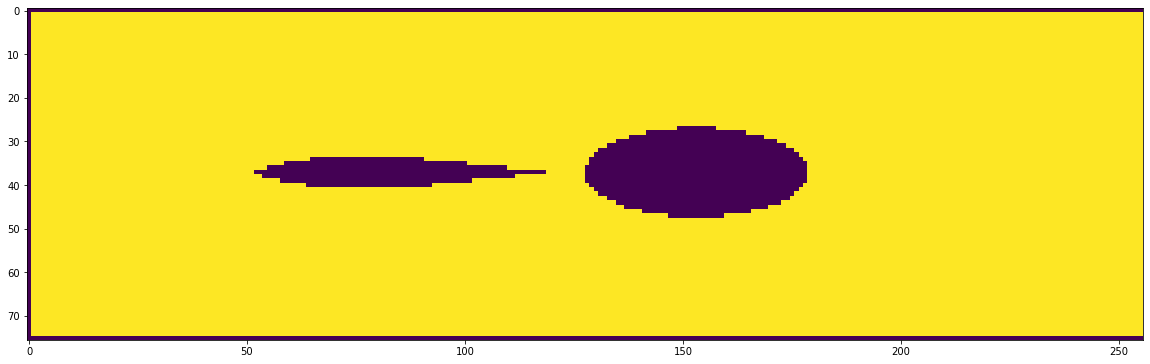

In [10]:
F = Fluid(Lx=1.0, Ly=.3,res=256)
inVel = .10
F.s[:,:] = 1          
            
#F.add_circle(0.32,0.5,0.1)
#F.add_circle(0.62,0.5,0.1)
#F.add_triangle(0.3,0.5,0.3,0.1)
#F.add_triangle(0.7,0.5,-.1,0.1)
F.add_ellipse( 0.6,0.15, 0.1,0.04,0. )
#F.add_ellipse( 0.4,0.23 , 0.1,0.01, 0.25 )
#F.add_ellipse( 0.4,0.07 , 0.1,0.01,-0.25 )

#F.add_triangle( (0.4,0.15) ,(0.3,0.2), (0.3,0.1) )
#F.add_triangle( (0.1,0.15) ,(0.3,0.2), (0.3,0.1) )

x0 = 0.2   # position on x of the leading edge when not rotated
y0 = 0.15  # position on y of the center of the symmetric not rotated wing
l  = 0.3   # chord length of the wing
pp = 0.1   # location [0-1] of max camber
pm = -0.   # scale factor [0-100] for the camber
pr = 10.   # scale factor [0-100] for the thickness
theta = -0.0 # rotation of the wing

for cx in np.linspace(x0,x0+l,int(l*F.Nx)):
    tx = (cx-x0)/l # 0 to 1 over the wing
    if tx < pp:
        ty = pm / 100 * (2*tx*pp-tx*tx) / pp**2
    else:
        ty = pm / 100 * ((1-2*pp)+2*tx*pp-tx*tx) / (1-pp)**2
        
    r = tx*(1-tx)**2 * pr / 100
    
    x = cx * np.cos(theta) - (ty+y0) * np.sin(theta)
    y = cx * np.sin(theta) + (ty+y0) * np.cos(theta)
    
#    F.add_circle(cx,ty+y0,r)
    F.add_circle(x,y,r)

for i in range(0,F.Nx):
    for j in range(0,F.Ny):
        if i==0 or j==0 or j == F.Ny-1:
            F.s[i,j] = 0
        if i==1:
            F.u[i,j] = inVel
        if i==F.Nx-2:
            F.u[i,j] = inVel
            
plt.figure(figsize=(20,20))
plt.imshow(F.s.T[::-1])

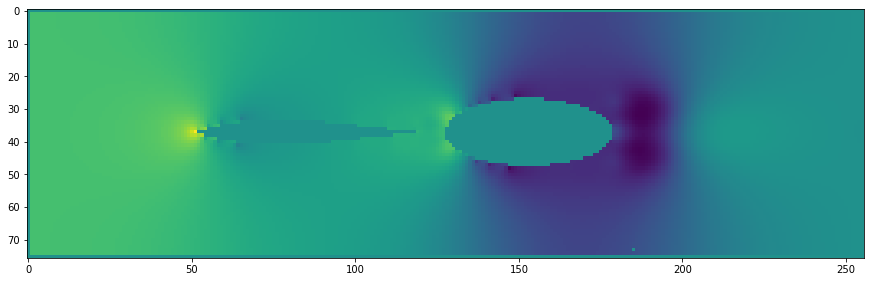

In [11]:
fig,ax = plt.subplots(1,1, figsize=(15, 15))
hdisplay = display.display("", display_id=True)

itr = 0
while True:
    try:
        F.simulate(1/120., 0.0, 300)
        F.plot('p',ax,fig,hdisplay)
        itr += 1

    except KeyboardInterrupt:
        break
plt.close(fig)

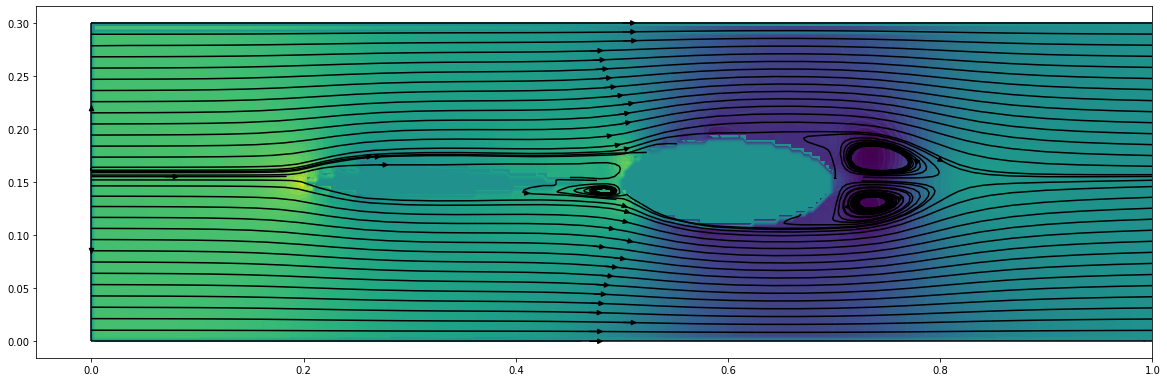

In [12]:
plt.figure(figsize=(20,20))
plt.contour(F.x, F.y, F.p, levels=32)
plt.imshow(F.p.T[::-1],extent=[0,F.Lx,0,F.Ly])

sp = np.zeros((F.Ny,2))
sp[:,1] = F.y[0]
sp[:,0] = 0.9

plt.streamplot(
    F.grid_x,F.grid_y,F.u.T, F.v.T,
    density=1,
    color='black',#F.p.T, 
    broken_streamlines=False)
    #,start_points=sp[::4])
#plt.plot(sp.T[0],sp.T[1],'bo')

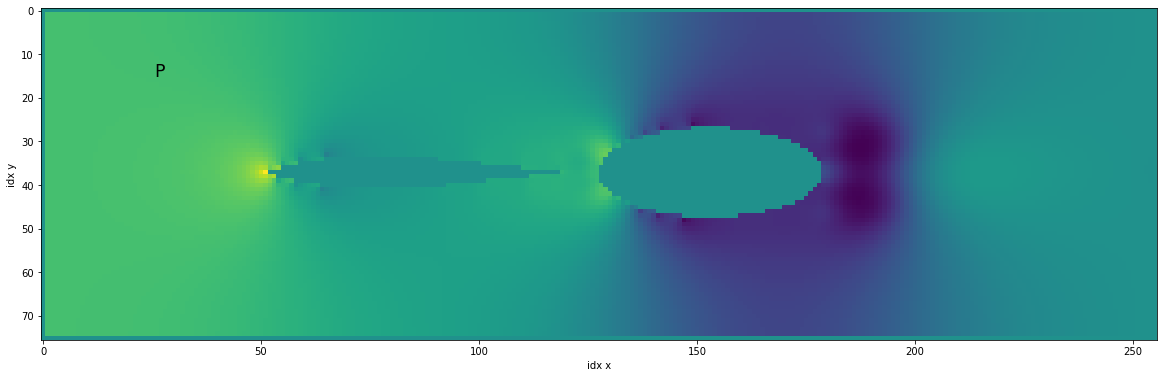

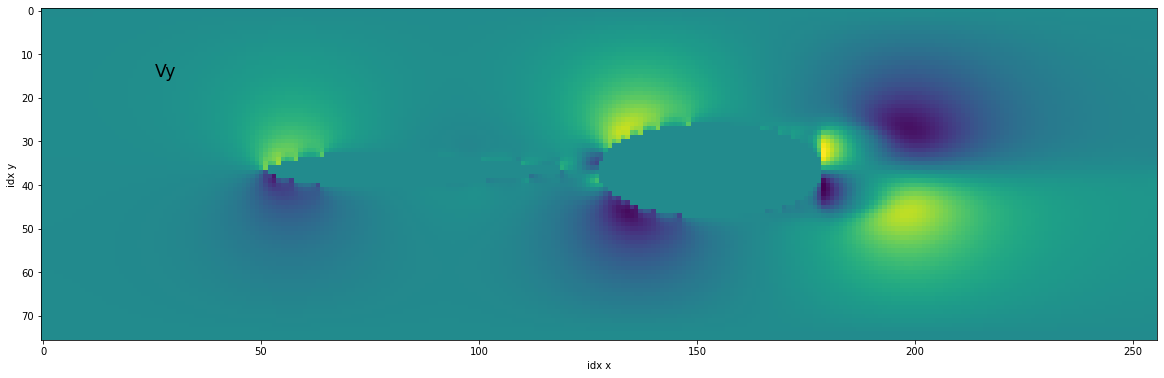

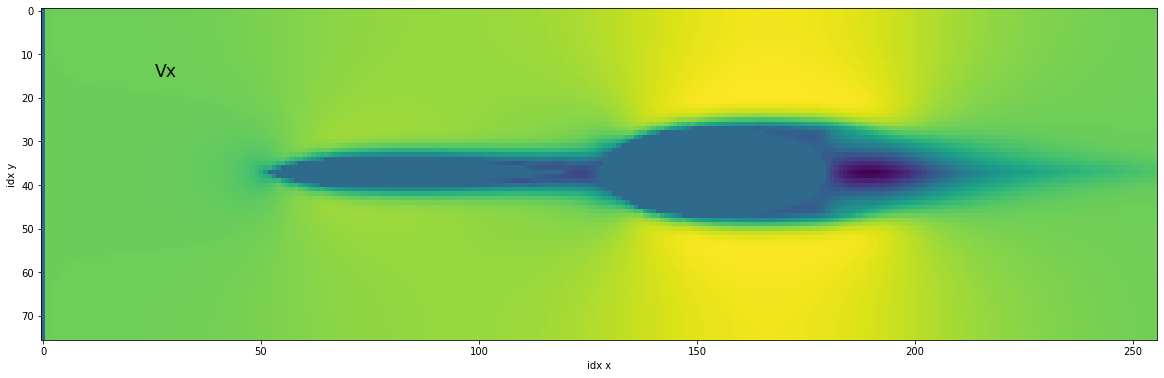

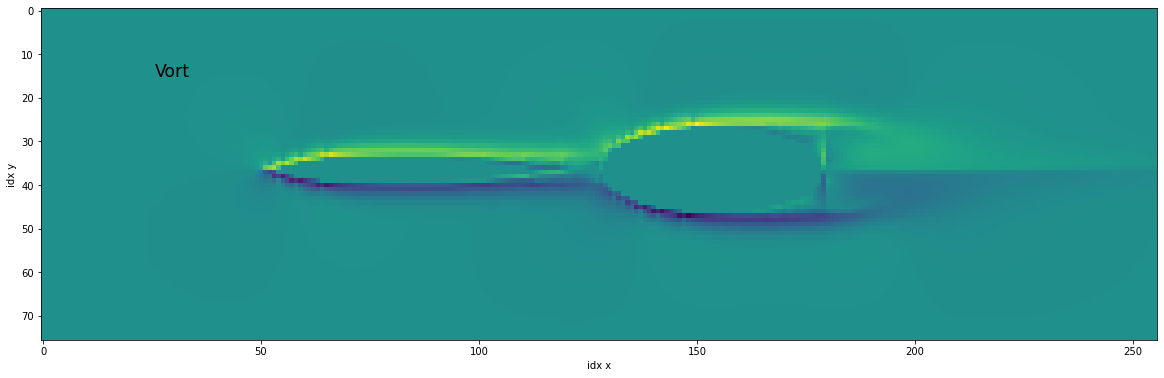

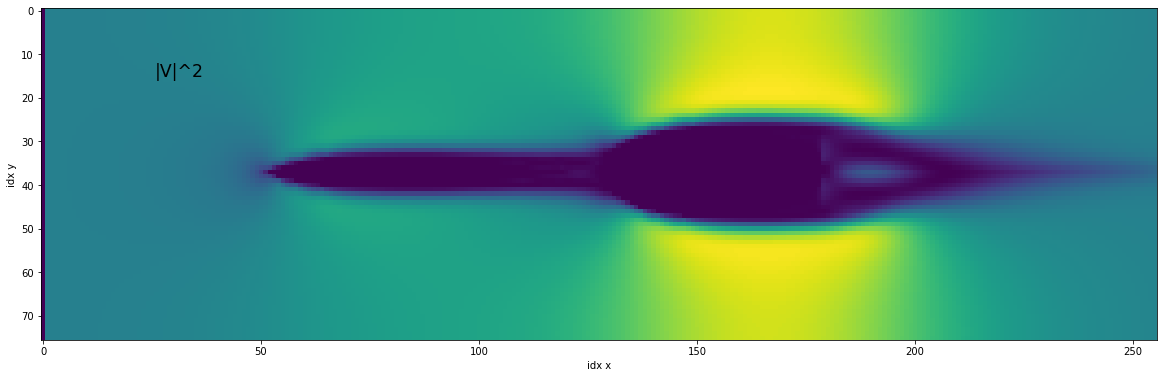

In [13]:
plt.figure(figsize=(20,20))
plt.text(F.Nx*0.1,F.Ny*0.2,'P',fontsize='xx-large')
plt.xlabel('idx x')
plt.ylabel('idx y')
plt.imshow(F.p.T[::-1])
plt.show()

plt.figure(figsize=(20,20))
plt.text(F.Nx*0.1,F.Ny*0.2,'Vy',fontsize='xx-large')
plt.xlabel('idx x')
plt.ylabel('idx y')
plt.imshow(F.v.T[::-1])
plt.show()

plt.figure(figsize=(20,20))
plt.text(F.Nx*0.1,F.Ny*0.2,'Vx',fontsize='xx-large')
plt.xlabel('idx x')
plt.ylabel('idx y')
plt.imshow(F.u.T[::-1])
plt.show()

plt.figure(figsize=(20,20))
plt.text(F.Nx*0.1,F.Ny*0.2,'Vort',fontsize='xx-large')
plt.xlabel('idx x')
plt.ylabel('idx y')
F.w = np.zeros_like(F.u)
F.w[1:,:]  = F.v[1:,:] - F.v[:-1,:]
F.w[:,1:] += F.u[:,1:] - F.u[:,:-1]
plt.imshow(F.w.T[::-1])
plt.show()

plt.figure(figsize=(20,20))
plt.text(F.Nx*0.1,F.Ny*0.2,'|V|^2',fontsize='xx-large')
plt.xlabel('idx x')
plt.ylabel('idx y')
F.k = F.u**2 + F.v**2 
plt.imshow(F.k.T[::-1])
plt.show()


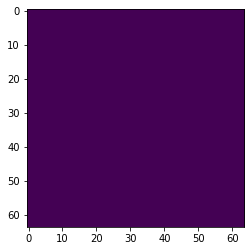

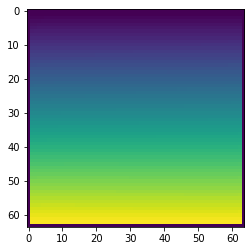

In [14]:
####### TANK ############

F = Fluid()

F.s[:,:] = 1
for i in range(0,F.Nx):
    for j in range(0,F.Ny):
        if i==0 or j==0 or i == F.Nx-1:
            F.s[i,j] = 0


plt.imshow(F.p.T[::-1])
plt.show()

for _ in range(60):
    F.simulate(1/60., -10.0, 40)
plt.imshow(F.p.T[::-1])
plt.show()
